# Titanic Survivability Linear Learner in SageMaker

## Prerequisites and Data <a class="anchor" id="pre_and_data">
### Initialize SageMaker  <a class="anchor" id="initsagemaker">
Add the data files for training set, test set and validation set

In [122]:
import sagemaker
from sagemaker import Session
bucket = 'ml-i6-breakingcode'
prefix = 'sagemaker/ebsco-titanic-survivabiity'

# Define IAM role
import re
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import urllib
import os
import sklearn.preprocessing as preprocessing
import seaborn as sns

role = get_execution_role()
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
training_set = pd.read_csv(data_location)
print("1. finished uploading training set")

#data_key = 'test.csv'
#data_location = 's3://{}/{}'.format(bucket, data_key)
#test_set = pd.read_csv(data_location)
#print("2. finished uploading test set")

data_key = 'gender_submission.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
validation_set= pd.read_csv(data_location)
print("3. finished uploading validation set")

1. finished uploading training set
3. finished uploading validation set


### Data Manipulation <a class="anchor" id="inspect_data">
Remove columns that doesn't affect the analysis from the training set

In [123]:
clean_data = training_set.drop("Name", axis = 1)
clean_data.head()
clean_data = clean_data.drop("Ticket", axis = 1)
clean_data.head()
clean_data = clean_data.drop("Cabin", axis = 1)
clean_data.head()
clean_data = clean_data.drop("PassengerId", axis = 1)
clean_data.head()
clean_data = pd.get_dummies(clean_data, columns = ["Sex"])
clean_data.head()
clean_data = pd.get_dummies(clean_data, columns = ["Embarked"])
clean_data.head()
clean_data = clean_data.dropna(how='any',axis = 0)
clean_data.head()

removeheader=clean_data.drop(clean_data.index[0])
train_data, validation_data, test_data = np.split(removeheader.sample(frac=1, random_state=1729), [int(0.7 * len(removeheader)), int(0.9 * len(removeheader))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Upload the train set and validation set into s3 bucket

In [124]:
import boto3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### Data inspection  <a class="anchor" id="inspect_data">
Plotting histograms of the distribution of the different features is a good way to visualize the data. We plot both the whole dataset distributions (left) and the distrubtions in the case of positive labels only (right).

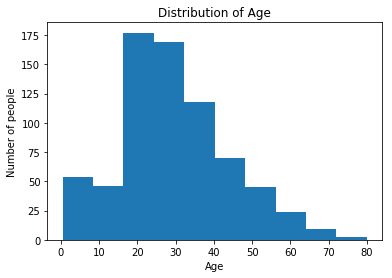

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

data = clean_data['Age']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Age')
plt.title('Distribution of Age')
plt.show()

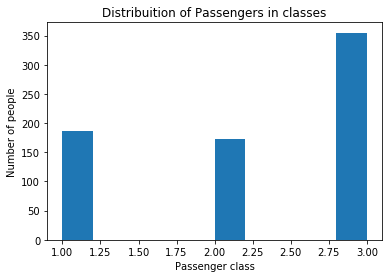

In [126]:
data = clean_data['Pclass']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Passenger class')
plt.title('Distribuition of Passengers in classes')
plt.show()

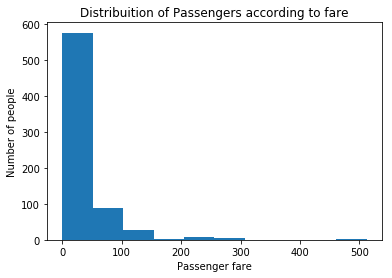

In [127]:
data = clean_data['Fare']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Passenger fare')
plt.title('Distribuition of Passengers according to fare')
plt.show()

## Standard linear model  <a class="anchor" id="train_linear_model">

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [128]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner',"latest")

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='text/csv')

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=10,
                           predictor_type='binary_classifier',
                           mini_batch_size=50)

linear.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-07-02 19:44:19 Starting - Starting the training job...
2019-07-02 19:44:21 Starting - Launching requested ML instances......
2019-07-02 19:45:24 Starting - Preparing the instances for training......
2019-07-02 19:46:28 Downloading - Downloading input data...
2019-07-02 19:47:13 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[07/02/2019 19:47:33 INFO 140238634960704] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall'

### Accuracy and Fairness of the model <a class="anchor" id="performance_linear_model">
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

In [129]:
from sagemaker.predictor import csv_serializer
linear_predictor_breakingcode = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

linear_predictor_breakingcode.content_type = 'text/csv'
linear_predictor_breakingcode.serializer = csv_serializer
linear_predictor_breakingcode.deserializer = None

---------------------------------------------------------------------------------------------------!

Prediction for the test data.

In [223]:
def predict(data, rows=len(test_data)):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    new_predictions = ''
    for array in split_array:
        new_predictions = ','.join([new_predictions, linear_predictor_breakingcode.predict(array).decode('utf-8')])
    return new_predictions[1:].split(',')

predictions = predict(test_data.as_matrix()[:, 1:])


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Predictions

In [226]:
len(predictions)

144